In [1]:
import torch
from diffusion.model.builder import build_model, get_tokenizer_and_text_encoder, get_vae, vae_decode, vae_encode
from diffusion.model.utils import get_weight_dtype
from omegaconf import OmegaConf

from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import InterpolationMode, to_pil_image
from diffusion.data.datasets.utils import ASPECT_RATIO_2048, ASPECT_RATIO_2880, ASPECT_RATIO_1024
from diffusion.data.transforms import get_closest_ratio

import io
import re
import sys
import time
import json
import tarfile
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image


/home/hpc/vlgm/vlgm116v/.conda/envs/himat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0130 20:43:18.798621 2190850 site-packages/torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/home/hpc/vlgm/vlgm116v/.conda/envs/himat'
/home/hpc/vlgm/vlgm116v/.conda/envs/himat/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/hpc/vlgm/vlgm116v/MatGen/Sana/diffusion/model/wan/model.py:124: FutureWarning: `torch.cuda.amp.autoc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_tar_file(tar_filename):
    data_dict = {}
    with tarfile.open(tar_filename, 'r') as tar:
        for member in tar.getmembers():
            f = tar.extractfile(member)
            if f is not None:
                if member.name.endswith('.npy'):
                    buffer = io.BytesIO(f.read())
                    data = np.load(buffer)
                    data_dict[member.name] = data
                elif member.name.endswith('.json'):
                    data = json.load(f)
                    data_dict[member.name] = data
    return data_dict


def preprocess_img(x):
    ############# OLD VERSION: to_tensor was not handinling height map's uint16 properly #############
    # x = TF.resize(x, (1024, 1024), interpolation=InterpolationMode.BICUBIC)
    # x = TF.to_tensor(x).to(torch.float32)
    # x = TF.normalize(x, mean=[0.5], std=[0.5])
    # return x
    ##################################################################################################
    x = TF.resize(x, (1024, 1024), interpolation=TF.InterpolationMode.BICUBIC)
    x_np = np.array(x)
    if x_np.dtype == np.uint8:
        x_np = x_np.astype(np.float32) / 255.0
    elif x_np.dtype == np.uint16:
        x_np = x_np.astype(np.float32) / 65535.0
    else:
        raise ValueError(f"Unsupported image dtype: {x_np.dtype}")
    if x_np.ndim == 3:
        x_np = np.transpose(x_np, (2, 0, 1))  # HWC to CHW
    elif x_np.ndim == 2:
        x_np = x_np[np.newaxis, :, :]  # HW to 1HW

    x = torch.from_numpy(x_np)
    x = TF.normalize(x, mean=[0.5], std=[0.5])
    return x
    

def create_img_features(img, config):
    with torch.no_grad():
        z = vae_encode(config.vae.vae_type, vae, img, config.vae.sample_posterior, device)

    return z

In [4]:
config = OmegaConf.load("configs/sana1-5_config/1024ms/Sana_1600M_1024px_allqknorm_bf16_lr2e5.yaml")
config['vae']['vae_pretrained'] = "/home/woody/vlgm/vlgm116v/huggingface/hub/models--mit-han-lab--dc-ae-f32c32-sana-1.1-diffusers/snapshots/6f7b3f3b289a439a11ef4fb1034989fd4b9a4766"
config.vae.weight_dtype = "float32" # set as per default value in AEConfig
vae_dtype = get_weight_dtype(config.vae.weight_dtype)
vae = get_vae(config.vae.vae_type, config.vae.vae_pretrained, device).to(vae_dtype)
print(f"Successfully built model components.")

[AutoencoderDC] Loading model from /home/woody/vlgm/vlgm116v/huggingface/hub/models--mit-han-lab--dc-ae-f32c32-sana-1.1-diffusers/snapshots/6f7b3f3b289a439a11ef4fb1034989fd4b9a4766
Successfully built model components.


In [5]:
img = Image.open('output/girl.png').convert('RGB')
img = preprocess_img(img).unsqueeze(0).to(device)
compressed_img = create_img_features(img, config)
print(f"compressed_img.shape: {compressed_img.shape}")

compressed_img.shape: torch.Size([1, 32, 32, 32])


In [6]:
with torch.no_grad():
    img = vae_decode(config.vae.vae_type, vae, compressed_img)
    img = (img / 2 + 0.5).clamp(0, 1) # to [0, 1]
    print(f"Reconstructed img.shape: {img.shape}")

Reconstructed img.shape: torch.Size([1, 3, 1024, 1024])


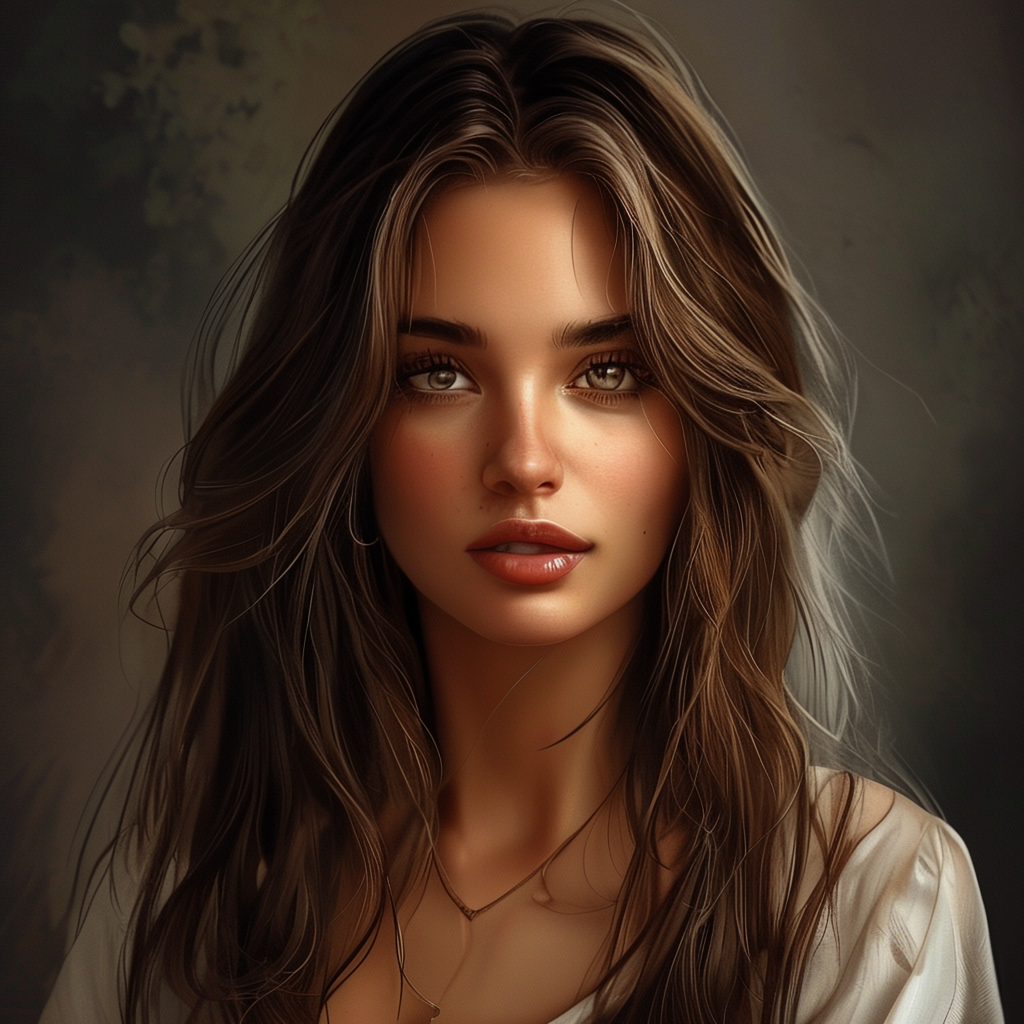

In [7]:
to_pil_image(img[0].cpu())

In [8]:
# tar_filename = glob("/home/woody/vlgm/vlgm116v/matsynth/data/*.tar")[0]
# tar_filename = glob("/home/woody/vlgm/vlgm116v/matsynth/data/train-00102-of-00431.tar")[0]
tar_filename = "data/debug_data/train-00102-of-00431.tar"
data_dict = load_tar_file(tar_filename)
print(data_dict.keys())

dict_keys(['swamp_creature.npy', 'swamp_creature.json', 'swamp_creature1.npy', 'swamp_creature1.json'])


In [13]:
key = list(filter(lambda x: x.endswith('.npy'), list(data_dict.keys())))[1]
print(f"Loaded key: {key} from tar file: {tar_filename}")
svbrdf_features = data_dict[key]
prompt = data_dict[key.replace('.npy', '.json')]['prompt']
svbrdf_features = torch.from_numpy(svbrdf_features).to(device)
print(f"prompt: {prompt}")
print(f"svbrdf_features.shape: {svbrdf_features.shape}")

Loaded key: swamp_creature1.npy from tar file: data/debug_data/train-00102-of-00431.tar
prompt: This surface presents a uniform, matte grey background, resembling an aged, subtly textured wallpaper or a concrete wall. Irregular, darker grey patches are scattered across the surface, giving the impression of moisture damage or mold growth. The texture is finely granular, creating a soft, almost fuzzy appearance with no distinct patterns or sharp features.
svbrdf_features.shape: torch.Size([3, 32, 32, 32])


In [14]:
with torch.no_grad():
    img = vae_decode(config.vae.vae_type, vae, svbrdf_features)
    img = (img / 2 + 0.5).clamp(0, 1) # to [0, 1]
    print(f"Reconstructed img.shape: {img.shape}")

Reconstructed img.shape: torch.Size([3, 3, 1024, 1024])


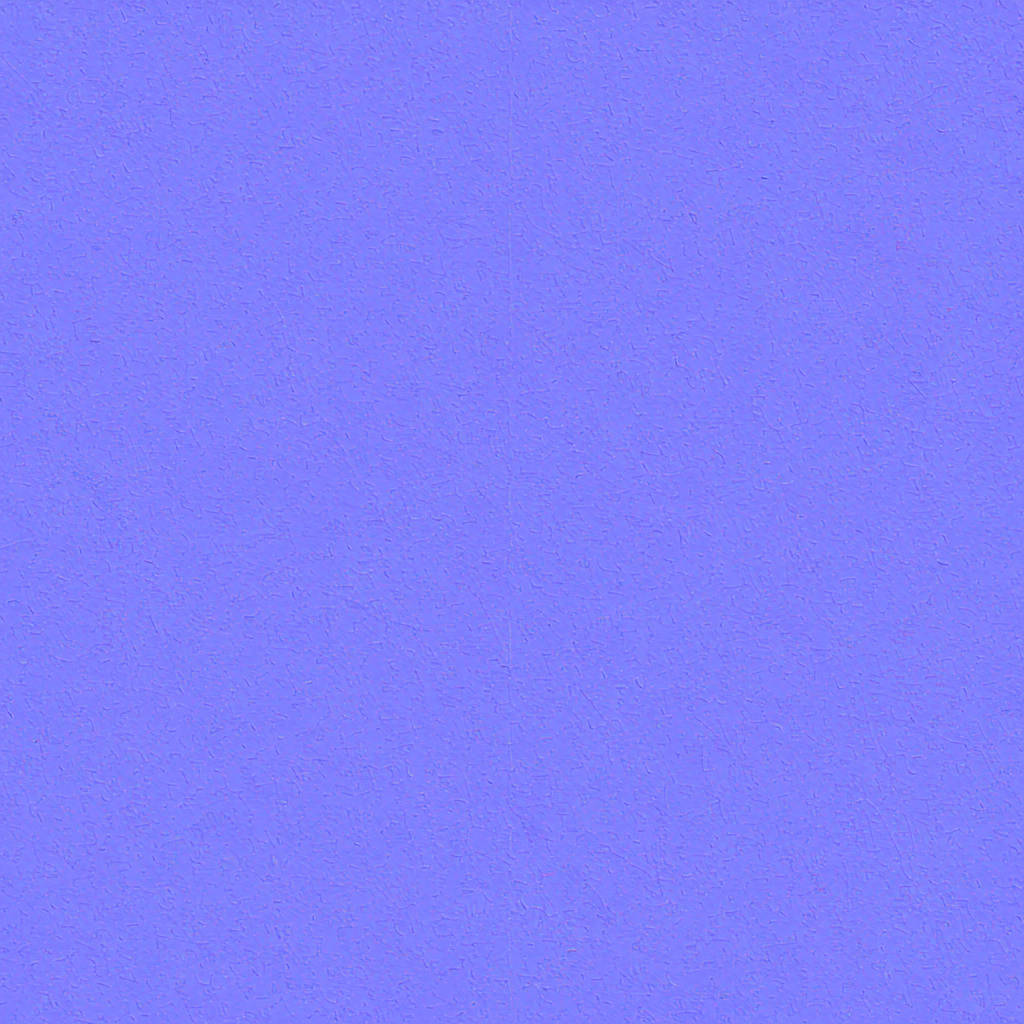

In [24]:
to_pil_image(img[1].cpu())

In [24]:
{
        list(data_dict.keys())[2]: data_dict[list(data_dict.keys())[2]],
        list(data_dict.keys())[3]: data_dict[list(data_dict.keys())[3]],
    }.keys()

dict_keys(['swamp_creature.npy', 'swamp_creature.json'])

In [32]:
def save_dict_as_tar(data_dict, tar_filename):
    with tarfile.open(tar_filename, 'w') as tar:
        for key, value in data_dict.items():
            data_bytes = io.BytesIO()
            if key.endswith('.npy'):
                np.save(data_bytes, value)
            elif key.endswith('.json'):
                json_str = json.dumps(value)
                data_bytes.write(json_str.encode('utf-8'))
            else:
                continue
            data_bytes.seek(0)
            tarinfo = tarfile.TarInfo(name=key)
            tarinfo.size = len(data_bytes.getbuffer())
            tar.addfile(tarinfo, fileobj=data_bytes)

save_dict_as_tar(
    {
        list(data_dict.keys())[2]: data_dict[list(data_dict.keys())[2]],
        list(data_dict.keys())[3]: data_dict[list(data_dict.keys())[3]],
        list(data_dict.keys())[2].replace(".npy", "1.npy"): data_dict[list(data_dict.keys())[2]],
        list(data_dict.keys())[3].replace(".json", "1.json"): data_dict[list(data_dict.keys())[3]],
    },
    "data/debug_data/train-00102-of-00431.tar"
)

In [27]:
load_tar_file("data/debug_data/train-00102-of-00431.tar").keys()

dict_keys(['swamp_creature.npy', 'swamp_creature.json'])

In [31]:
{
        list(data_dict.keys())[2]: data_dict[list(data_dict.keys())[2]],
        list(data_dict.keys())[3]: data_dict[list(data_dict.keys())[3]],
        list(data_dict.keys())[2].replace(".npy", "1.npy"): data_dict[list(data_dict.keys())[2]],
        list(data_dict.keys())[3].replace(".json", "1.json"): data_dict[list(data_dict.keys())[3]],
    }

{'swamp_creature.npy': array([[[[-1.0633491 , -0.47955397, -0.5279555 , ..., -0.30623946,
            0.01842425, -0.8183875 ],
          [-0.9190586 , -0.32889703,  0.32843113, ..., -0.58250767,
            0.24256176, -0.7509591 ],
          [-0.45413762, -1.6606694 , -1.0561464 , ...,  0.6225157 ,
            0.1590298 ,  0.4820499 ],
          ...,
          [-0.04391038,  0.39964715,  0.29846063, ..., -0.9928011 ,
           -0.16389526, -0.21024519],
          [-0.37232625,  0.13142212,  0.41313556, ...,  0.76789796,
           -0.1941775 ,  0.22040209],
          [-0.27527854, -0.398978  , -0.5447562 , ..., -0.4811408 ,
            0.06097211, -0.7905762 ]],
 
         [[ 0.8242351 , -0.9104641 , -0.6572333 , ...,  0.1736335 ,
           -0.12639159, -0.512755  ],
          [ 0.41422322,  0.00866358, -0.3411563 , ...,  0.02306196,
            0.18514553, -0.05016955],
          [-0.6953582 ,  0.75436866,  0.33415592, ..., -0.15500563,
           -0.19351782, -0.17463087],
      

In [12]:
import json 

wids_meta = json.load(open("/home/woody/vlgm/vlgm116v/matsynth/data/wids-meta.json", 'r'))

total_samples = 0
for shard_info in wids_meta['shardlist']:
    total_samples += shard_info['nsamples']

print(f"Total samples in Matsynth dataset: {total_samples}")

Total samples in Matsynth dataset: 1176


In [13]:
1176//2

588

### Creating text embeddings for validation

In [73]:
import torch
from diffusion.model.builder import get_tokenizer_and_text_encoder
from omegaconf import OmegaConf

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
def create_text_features(text, config):
    with torch.no_grad():
        if not config.text_encoder.chi_prompt:
            max_length_all = config.text_encoder.model_max_length
            prompt = text
        else:
            chi_prompt = "\n".join(config.text_encoder.chi_prompt)
            # prompt = [chi_prompt + i for i in batch[1]]
            prompt = [chi_prompt + i for i in text]
            print(prompt)
            num_sys_prompt_tokens = len(tokenizer.encode(chi_prompt))
            max_length_all = (
                num_sys_prompt_tokens + config.text_encoder.model_max_length - 2
            )  # magic number 2: [bos], [_]
        txt_tokens = tokenizer(
            prompt,
            padding="max_length",
            max_length=max_length_all,
            truncation=True,
            return_tensors="pt",
        ).to(device)
        select_index = [0] + list(
            range(-config.text_encoder.model_max_length + 1, 0)
        )  # first bos and end N-1
        # print(text_encoder(txt_tokens.input_ids, attention_mask=txt_tokens.attention_mask)[0].shape)
        y = text_encoder(txt_tokens.input_ids, attention_mask=txt_tokens.attention_mask)[0][:, select_index, :]
        y_mask = txt_tokens.attention_mask[:, select_index]
        # print(f"select_index: {select_index}")
        # print(f"y.shape: {y.shape}, y_mask.shape: {y_mask.shape}")

    return y, y_mask

In [76]:
prompts = [
    "A nice detailed wood pattern for a backdrop, texture or background",
    "Crack old brick wall in a background",
    "Closeup detail of red leather texture background",
    "Crystalline, jagged surface of a quartz crystal",
    "a cobblestone street pavement texture"
]

In [77]:
cfg = OmegaConf.load("configs/sana1-5_config/1024ms/Sana_1600M_1024px_allqknorm_bf16_lr2e5.yaml")
global tokenizer, text_encoder

In [78]:
tokenizer, text_encoder = get_tokenizer_and_text_encoder(
        name=config.text_encoder.text_encoder_name, device=device
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 27.24it/s]


In [79]:
save_path = "/home/hpc/vlgm/vlgm116v/MatGen/Sana/output/tmp_embed/62b9ab89eebb0ac5ee4d264bf96bf19d2b81f504bc3852500efeaf5a34d638b1/"

text_feat, text_mask = create_text_features(prompts, cfg)
for i, pmpt in enumerate(prompts):
    # print(f"text_feat.shape: {text_feat.shape}, text_mask.shape: {text_mask.shape}")
    torch.save(
        {
            "caption_embeds": text_feat[i].unsqueeze(0).cpu(),
            "emb_mask": text_mask[i].unsqueeze(0).cpu(),
        },
        f"{save_path}/{pmpt[:50]}_300token_gemma-2-2b-it_2304.pth",
    )

['Given a user prompt, generate an "Enhanced prompt" that provides detailed visual descriptions suitable for image generation. Evaluate the level of detail in the user prompt:\n- If the prompt is simple, focus on adding specifics about colors, shapes, sizes, textures, and spatial relationships to create vivid and concrete scenes.\n- If the prompt is already detailed, refine and enhance the existing details slightly without overcomplicating.\nHere are examples of how to transform or refine prompts:\n- User Prompt: A cat sleeping -> Enhanced: A small, fluffy white cat curled up in a round shape, sleeping peacefully on a warm sunny windowsill, surrounded by pots of blooming red flowers.\n- User Prompt: A busy city street -> Enhanced: A bustling city street scene at dusk, featuring glowing street lamps, a diverse crowd of people in colorful clothing, and a double-decker bus passing by towering glass skyscrapers.\nPlease generate only the enhanced description for the prompt below and avoid 

In [80]:
# temp = torch.load("/home/hpc/vlgm/vlgm116v/MatGen/Sana/output/tmp_embed/62b9ab89eebb0ac5ee4d264bf96bf19d2b81f504bc3852500efeaf5a34d638b1/A photo of beautiful mountain with realistic sunse_300token_gemma-2-2b-it_2304.pth")
temp = torch.load("/home/hpc/vlgm/vlgm116v/MatGen/Sana/output/tmp_embed/62b9ab89eebb0ac5ee4d264bf96bf19d2b81f504bc3852500efeaf5a34d638b1/a cobblestone street pavement texture_300token_gemma-2-2b-it_2304.pth")

In [82]:
temp['caption_embeds'].shape, temp['emb_mask'].shape

(torch.Size([1, 300, 2304]), torch.Size([1, 300]))

In [84]:
x = temp['caption_embeds'].repeat(3, 1, 1)

In [93]:
torch.tensor([[1024, 1024]], dtype=torch.float).repeat(3, 1)

tensor([[1024., 1024.],
        [1024., 1024.],
        [1024., 1024.]])

In [96]:
null_embed = torch.load("/home/hpc/vlgm/vlgm116v/MatGen/Sana/output/pretrained_models/null_embed_diffusers_gemma-2-2b-it_300token_2304.pth", map_location="cpu")
print(null_embed['uncond_prompt_embeds'].shape, null_embed['uncond_prompt_embeds_mask'].shape)

torch.Size([1, 300, 2304]) torch.Size([1, 300])
